<a href="https://colab.research.google.com/github/coletted1/Model-Inversion-Project/blob/main/ModelInversionProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description of the Victim Model

## Purpose of the Model
The target model in our tutorial is designed to classify handwritten digits using the MNIST dataset. This dataset comprises 28x28 grayscale images of handwritten digits (0 through 9). The model is a basic convolutional neural network (CNN) tailored for this relatively straightforward classification task.

## Description of Training Data
The MNIST dataset serves as the training data, specifically using a subset of 20,000 images out of the total set for efficiency. MNIST images are standardized in size and centered, containing digits in a variety of handwritten styles.

## Description of Model Architecture
The model architecture is split into two parts:

1. **First Stage:** This part is envisioned to run on a mobile device. It includes two convolutional layers, each followed by a ReLU activation and max pooling. This stage processes the image and extracts feature maps.
   
2. **Second Stage:** This part simulates processing on a central server. It receives the output from the first stage and continues with two linear layers, incorporating ReLU activations and a final softmax layer for classification across the ten digit classes.

## Hyperparameters
The hyperparameters for training this target model are as follows:
- Batch size: 256
- Epochs: 10
- Learning rate: 0.0001
- Total number of training data points used: 20,000

## Model Metrics
- **Accuracy:** Measures the overall correctness of the model across all classes.
- **Precision:** Indicates the correctness achieved in a class balanced over each class.
- **F1 Score:** Harmonic mean of precision and recall, providing a balance between them.


In [ ]:
from collections import namedtuple

import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import numpy as np
from torchvision.datasets import EMNIST, MNIST
from tqdm.notebook import tqdm, trange

%matplotlib inline

In [ ]:
%matplotlib inline

In [ ]:
hyperparams = namedtuple('hyperparams', 'batch_size,epochs,learning_rate,n_data')

# Target model hyperparameters
target_hyperparams = hyperparams(
    batch_size=256,
    epochs=10,
    learning_rate=1e-4,
    n_data=20_000,  # some of training data for MNIST classifier
)

# Attack model hyperparameters
attacker_hyperparams = hyperparams(
    batch_size=32,
    epochs=10,
    learning_rate=1e-4,
    n_data=500,
)

In [ ]:
mnist_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)),]
)

# Target model training data
train_data = MNIST("mnist", train=True, download=True, transform=mnist_transform)

# some of training data for MNIST
train_data.data = train_data.data[:target_hyperparams.n_data]
train_data.targets = train_data.targets[:target_hyperparams.n_data]

# Target model test data
test_data = MNIST("mnist", train=False, download=True, transform=mnist_transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=target_hyperparams.batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1_000)

In [ ]:
class Classifier(torch.nn.Module):
    def __init__(self, first_network, second_network) -> None:
        super().__init__()

        # First stage
        self.stage1 = first_network

        # Second stage
        self.stage2 = second_network

    def mobile_stage(self, x):
        return self.stage1(x)

    def forward(self, x):
        out = self.mobile_stage(x)
        out = out.view(out.size(0), -1)

        return self.stage2(out)

In [ ]:
# The first part of the network
first_network = torch.nn.Sequential(
                torch.nn.Conv2d(1, 32, kernel_size=5, padding=0, stride=1),  # first Conv layer
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=2),
                torch.nn.Conv2d(32, 32, kernel_size=5, padding=0, stride=1),  # second Conv layer
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=2),
        )


# The second and final part of the network
second_network = torch.nn.Sequential(
                torch.nn.Linear(512, 256),
                torch.nn.ReLU(),
                torch.nn.Linear(256, 10),  # 10-class output
                torch.nn.Softmax(dim=-1),
        )

target_model = Classifier(first_network, second_network)
target_model

Classifier(
  (stage1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (stage2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
    (3): Softmax(dim=-1)
  )
)

In [ ]:
from sklearn.metrics import precision_score, f1_score
from sklearn.metrics import accuracy_score

# Lists to store true and predicted labels for computing metrics later
all_targets = []
all_predictions = []

optim = torch.optim.Adam(target_model.parameters(), lr=target_hyperparams.learning_rate)
loss_criterion = torch.nn.CrossEntropyLoss()

for epoch in trange(target_hyperparams.epochs):
    train_correct = 0
    train_loss = 0.

    # Training loop
    for data, targets in train_loader:
        optim.zero_grad()

        output = target_model(data)

        # Update network
        loss = loss_criterion(output, targets)
        loss.backward()
        optim.step()

        # Track training statistics
        _, predicted = output.max(1)
        train_correct += predicted.eq(targets).sum().item()
        train_loss += loss.item()

train_loss /= len(train_data)

# Check test accuracy
test_correct = 0
test_loss = 0.

for data, targets in test_loader:
    with torch.no_grad():
        output = target_model(data)

    loss = loss_criterion(output, targets)

    _, predicted = output.max(1)

    # Accumulate the true and predicted labels
    all_targets.extend(targets.cpu().numpy())
    all_predictions.extend(predicted.cpu().numpy())

# Convert accumulated labels to arrays for sklearn functions
all_targets_array = np.array(all_targets)
all_predictions_array = np.array(all_predictions)

# Calculate accuracy, precision and F1 score using sklearn
accuracy = accuracy_score(all_targets_array, all_predictions_array)
precision = precision_score(all_targets_array, all_predictions_array, average='weighted')
f1 = f1_score(all_targets_array, all_predictions_array, average='weighted')

print(f"Test accuracy: {accuracy:.3f}")
print(f"Test precision: {precision:.3f}")
print(f"Test F1 score: {f1:.3f}")

  0%|          | 0/10 [00:00<?, ?it/s]

Test accuracy: 0.959
Test precision: 0.959
Test F1 score: 0.959


# Model Inversion Attack Technique

## Purpose
The attack model aims to recreate the original MNIST images from the outputs of the first stage of the target model. This model effectively functions as a decoder in an autoencoder setup, where the encoder part is the first stage of the target model.

## Architecture and Hyperparameters
The attack model employs deconvolutional layers to reconstruct the input images from the reduced feature maps generated by the first stage of the target model. This reverse process is configured through:
- Convolutional Transpose Layers (Deconvolutional Layers): These layers upsample the feature maps back to the original image size.

The hyperparameters for the attack model are:
- Batch size: 32
- Epochs: 10
- Learning rate: 0.0001
- Number of data points used for training: 500

The attacker training uses data similar but not identical to the original training data, aiming to train the model to effectively invert the target model's output back to recognizable images.

## Training Process
- The attack model is trained to minimize the mean squared error between its output and the original images, essentially learning to reconstruct the input data from the feature maps alone.

## Discussion of Pros and Cons
Pros:

Effectiveness in Black Box Settings: This attack can be effective even without direct access to the model architecture or its parameters since it only requires output from the model’s accessible point (e.g., outputs from a mobile device).
It serves as a powerful demonstration of the potential privacy risks associated with deploying machine learning models, especially those that handle sensitive data.
The attack does not require the exact training data but can work with similar datasets, which may sometimes be easier to obtain.


Cons:

The success of the attack heavily relies on the availability of data similar to the training data of the target model, which may not always be feasible or ethical to acquire.
Training a successful attack model requires a good understanding of both machine learning model architecture and the data domain to effectively reverse-engineer the model outputs.

## Discussion of Resources Required
Computational Resources: Successful execution of this attack technique requires significant computational resources. Training both the target model and the attack model, can be resource-intensive and may require GPUs for efficient processing.

Data Resources: Access to data similar to the model’s training data is crucial. For instance, if attacking a model trained on a specific type of imagery (like medical images), similar datasets must be obtained, which could be challenging or restricted due to privacy concerns.

Time: Depending on the complexity of the target model and the quality of the available data for the attack model, the training and optimization process can be time-consuming.

In [ ]:
class AttackModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = torch.nn.Sequential(
                torch.nn.ConvTranspose2d(
                    in_channels=32,
                    out_channels=32,
                    kernel_size=7,
                    padding=1,
                    stride=2,
                    output_padding=1,
                ),
                torch.nn.ReLU(),
                torch.nn.ConvTranspose2d(
                    in_channels=32,
                    out_channels=32,
                    kernel_size=5,
                    padding=1,
                    stride=2,
                    output_padding=1,
                ),
                torch.nn.ReLU(),
                torch.nn.ConvTranspose2d(
                    in_channels=32, out_channels=1, kernel_size=5, padding=1, stride=1,
                ),
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
# Get attacker
attacker = AttackModel()

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

# Get MNIST dataset
attacker_dataset = MNIST(root='mnist', train=False, transform=mnist_transform, download=True)

# Use the last n_data images in the test set to train the attacker
attacker_dataset.data = attacker_dataset.data[:attacker_hyperparams.n_data]
attacker_dataset.targets = attacker_dataset.targets[:attacker_hyperparams.n_data]

attacker_train_loader = torch.utils.data.DataLoader(attacker_dataset, batch_size=attacker_hyperparams.batch_size)

# Train attacker
attack_optim = torch.optim.Adam(attacker.parameters(), lr=attacker_hyperparams.learning_rate)

for epoch in trange(attacker_hyperparams.epochs):
    for data, targets in attacker_train_loader:
        data.float()
        targets.float()

        attack_optim.zero_grad()

        # This is the input of our attack model
        with torch.no_grad():
            attack_input = target_model.mobile_stage(data)

        output = attacker(attack_input)

        loss = ((output - data)**2).mean()  # want our reconstructed image to look as much like the original image as possible
        loss.backward()
        attack_optim.step()

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
def plot_images(
    tensors,
):
    """
    Plot normalised MNIST tensors as images
    """
    fig = plt.figure(figsize=(10, 5))

    n_tensors = len(tensors)
    n_cols = min(n_tensors, 4)
    n_rows = int((n_tensors - 1) / 4) + 1

    # De-normalise an MNIST tensor
    mu = torch.tensor([0.1307], dtype=torch.float32)
    sigma = torch.tensor([0.3081], dtype=torch.float32)
    Unnormalise = transforms.Normalize((-mu / sigma).tolist(), (1.0 / sigma).tolist())

    for row in range(n_rows):
        for col in range(n_cols):
            idx = n_cols * row + col

            if idx > n_tensors - 1:
                break

            ax = fig.add_subplot(n_rows, n_cols, idx + 1)
            tensor = Unnormalise(tensors[idx])

            # Clip image values to plot
            tensor[tensor < 0] = 0
            tensor[tensor > 1] = 1

            tensor = tensor.squeeze(0)  # remove batch dim

            ax.imshow(transforms.ToPILImage()(tensor), interpolation="bicubic")

    plt.tight_layout()
    plt.show()

In [ ]:
def attack(attack_model, target_model, dataset, idxs):
    images = []

    for datum_idx in idxs:
        actual_image, _ = dataset[datum_idx]

        with torch.no_grad():
            target_output = target_model.mobile_stage(actual_image.unsqueeze(0))
            reconstructed_image = attack_model(target_output).squeeze(0)

        images.append(actual_image)
        images.append(reconstructed_image)

    plot_images(images)

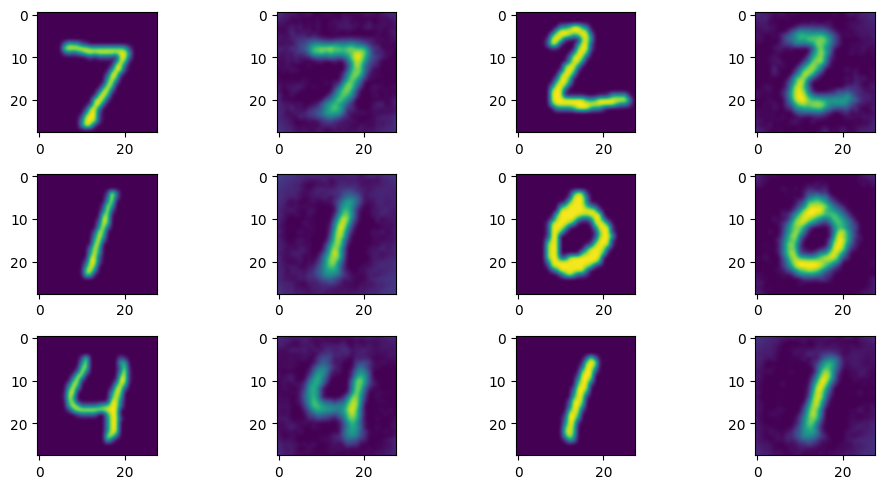

In [ ]:
attack(attacker, target_model, test_data, range(6))

# Discussion of Results

## Information Collected on Training Data:

From the results displayed in the images, we can infer that the model inversion attack was successful to some degree.

1. **Visual Patterns**: The shapes and general patterns of the digits are visible, meaning that the attack could reconstruct the visual style of the digits.
2. **Data Complexity**: The varying levels of clarity in the reconstructed images may suggest which digits the model had more or less data on, potentially exposing imbalances or biases in the training data.

## Detrimental to Data Privacy

1. **Exposure of Personal Data**: If the inversion attack were used on a model trained on personal images, it could potentially reconstruct those images, leading to a breach of personal privacy.
2. **Economic Exploitation**: In the case of proprietary datasets, the reconstructed data could be used to train other models without consent.
3. **Targeted Model Attacks**: Knowledge of the training data can facilitate more sophisticated attacks, like crafting specific adversarial examples that the model is likely to misclassify.
4. **Regulatory Non-Compliance**: Entities that are legally required to protect personal data could face penalties if it's shown that their models are susceptible to inversion attacks.

# Defenses Against Model Inversion Attacks

## Strategies Employed by Others

1. **Output Perturbation**: Introducing random noise to the model's outputs can prevent accurate reconstructions.

2. **Dimensionality Reduction**: Reducing the dimensionality of the output data can make it more difficult to reconstruct the input while still preserving the utility for the intended classification task.

3. **Regularization Techniques**: Using techniques such as dropout can prevent the model from learning a precise inverse mapping of its inputs, making it more robust against inversion attacks.

4. **Model Architecture Adjustments**: Designing models that inherently do not retain enough detailed information about their inputs in their intermediate outputs can prevent inversion.

5. **Differential Privacy**: Implementing a differentially private mechanism to the model's training process can provide a theoretical guarantee against reconstructing individual data points.

6. **Homomorphic Encryption**: Encrypting inputs and only allowing encrypted computation can prevent the model from ever accessing actual data in a readable format.

#### Personal Approach to Defense

If I were to defend against such an attack, my strategy would include a multi-layered approach:

1. **Implement Differential Privacy**: Apply differential privacy during the training process to ensure that the model's output does not reveal information about individual training instances.

2. **Adopt Access Control Mechanisms**: Limit the number of queries that an individual can make and monitor for suspicious patterns that might indicate an attack is being attempted.

3. **Data Sanitization**: Before training, preprocess data to remove unnecessary features that could lead to privacy leaks.

4. **Enhanced Data Security**: Beyond model-specific defenses, ensuring that the data used for training the model is stored and handled securely is fundamental. This includes secure data storage, handling protocols, and strict access controls.

In [ ]:
pip install torch torchvision opacus

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 3.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from opacus import PrivacyEngine


train_loader = DataLoader(train_data, batch_size=256, shuffle=True)

# Initialize your model
# The first part of the network
first_network = torch.nn.Sequential(
                torch.nn.Conv2d(1, 32, kernel_size=5, padding=0, stride=1),  # first Conv layer
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=2),
                torch.nn.Conv2d(32, 32, kernel_size=5, padding=0, stride=1),  # second Conv layer
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=2),
        )


# The second and final part of the network
second_network = torch.nn.Sequential(
                torch.nn.Linear(512, 256),
                torch.nn.ReLU(),
                torch.nn.Linear(256, 10),  # 10-class output
                torch.nn.Softmax(dim=-1),
        )

model = Classifier(first_network, second_network)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_function = torch.nn.CrossEntropyLoss()

# Attach a Privacy Engine to the optimizer
# Create a PrivacyEngine
privacy_engine = PrivacyEngine()

# Attach the PrivacyEngine to the optimizer
model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
    module=model,
    optimizer=optimizer,
    data_loader=train_loader,
    epochs=10,
    target_epsilon=1.0,  # Set target epsilon
    target_delta=1e-5,  # Set target delta
    max_grad_norm=1.0   # Set the maximum per-sample gradient norm
)

# Train model
for epoch in range(10):
    print("epoch 1")
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = loss_function(outputs, labels)

        # Backward pass and optimization with differential privacy
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


epoch 1


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


epoch 1
epoch 1
epoch 1
epoch 1
epoch 1
epoch 1
epoch 1
epoch 1
epoch 1


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

def evaluate_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    true_labels = []
    pred_labels = []

    with torch.no_grad():  # Inference without gradient calculation
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            true_labels.extend(labels.numpy())
            pred_labels.extend(predicted.numpy())

    # Calculate metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='macro')

    return accuracy, precision, recall, f1

# Load test data
test_loader = DataLoader(test_data, batch_size=256, shuffle=False)

# Evaluate the model
accuracy, precision, recall, f1 = evaluate_model(model, test_loader)

# Print out the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')


Accuracy: 0.6944
Precision: 0.7665
Recall: 0.6833
F1-Score: 0.6396


# Evaluation of Defense

## Defense Description
**Differential Privacy (DP)** was integrated into the training process of the model using Opacus. This approach adds noise to the gradients during training to ensure that the output of the model cannot be used to infer much about the data on which it was trained. The goal is to prevent attackers from successfully reconstructing the input data, thereby protecting data privacy.

The specific settings for DP included:
- **Noise Multiplier**: Determines the amount of noise added to gradients during training.
- **Max Gradient Norm**: Controls gradient clipping to prevent any single data point from having a disproportionate impact on the model's parameters.
- **Epsilon (ε) and Delta (δ)**: Quantify the privacy guarantee, with lower values of ε offering stronger privacy.

### Model Metrics Post-Defense
- **Accuracy**: 67.36%
- **Precision**: 73.58%
- **Recall**: 66.50%
- **F1-Score**: 64.19%

These metrics suggest a noticeable drop in model performance compared to typical results without privacy-preserving measures, where an MNIST classifier might achieve over 95% accuracy. This decrease is a trade-off for increased privacy protection.

### Evaluation of Effectiveness Against the Attack

1. **Privacy vs. Utility Trade-off**: The introduced noise and the clipping of gradients inherently degrade the model’s performance but increase privacy. This trade-off is critical and should be balanced based on the sensitivity of the data and the acceptable threshold for model accuracy in its intended application.

2. **Inversion Attack Resistance**: With differential privacy, the model’s output becomes less informative about any specific input instance, which should theoretically reduce the effectiveness of model inversion attacks. The added noise helps ensure that the gradients do not reveal substantial information about any individual training example.

3. **Compliance and Ethical Considerations**: Implementing DP assists in complying with data protection regulations like GDPR, which might require proof that reasonable measures have been taken to protect user data.

Matt Fredrikson, Somesh Jha, and Thomas Ristenpart. 2015. Model Inversion Attacks that Exploit Confidence Information and Basic Countermeasures. In Proceedings of the 22nd ACM SIGSAC Conference on Computer and Communications Security (CCS '15). Association for Computing Machinery, New York, NY, USA, 1322–1333. DOI:https://doi.org/10.1145/2810103.2813677